In [7]:
%cd /home/novelli/encoderops

/home/novelli/encoderops


In [98]:
import treescope
import torch
from dotenv import load_dotenv
from pathlib import Path
from src.model import EvolutionOperator
from src.data import DESRESDataset
from src.configs import ModelArgs # noqa
from torch.utils.data import RandomSampler
from torch_geometric.loader import DataLoader
from loguru import logger
from dataclasses import asdict
import linear_operator_learning as lol
import matplotlib.pyplot as plt
from src.data import mdtraj_load
import numpy as np
import os
from analysis.descriptors import compute_descriptors
import wandb
load_dotenv()

#treescope.basic_interactive_setup()


protein_id = "CLN025"
traj_id = 0
api = wandb.Api()

for run in api.runs(f"csml/encoderops-{protein_id}-{traj_id}"):
    updated: bool = False
    if run.state == "finished":
        data_path = Path(f"logs/encoderops-{protein_id}-{traj_id}/{run.id}")
        model = EvolutionOperator.load_from_checkpoint(next(data_path.glob("**/last.ckpt")))
        model_args = asdict(model.model_args)
        for k, v in model_args.items():
            if k not in run.config:
                run.config[k] = v
                updated = True
        run.update()
        if updated:
            logger.info(f"Updated run {run.id}")
        else:
            logger.info(f"Run {run.id} was already up to date")

def deterministic_sampler(dataset, subsample:float, seed: int, verbose: bool = True):
    generator = torch.Generator()
    generator.manual_seed(seed)
    num_samples = int(len(dataset)*subsample)
    if verbose:
        logger.info(f"Subsampling {num_samples} samples ({num_samples/len(dataset):.3f}%)")
    sampler = RandomSampler(dataset, num_samples=num_samples, generator=generator)
    return sampler


def load_run(run_id: str, protein_id: str, traj_id:int = 0, epoch: int | None = None, progress: bool = True, subsample: float | None = None):
    reg=1e-4
    rng_seed = 42
    batch_size = 1024
    data_path = Path(f"logs/encoderops-{protein_id}-{traj_id}/{run_id}")
    if epoch is None:
        model = EvolutionOperator.load_from_checkpoint(next(data_path.glob("**/last.ckpt")))
    else:
        model = EvolutionOperator.load_from_checkpoint(next(data_path.glob(f"**/epoch={epoch}*.ckpt")))
    dataset = DESRESDataset(model.data_args.protein_id, lagtime=model.data_args.lagtime)
    embeddings = {"t": [], "lag": []}
    model = model.eval()
    if subsample is not None:
        num_samples = int(len(dataset)*subsample)
        logger.info(f"Subsampling {num_samples} samples ({num_samples/len(dataset):.3f}%)")
        sample_idxs = [idx for idx in deterministic_sampler(dataset, subsample, rng_seed, verbose=False)]
        sampler = deterministic_sampler(dataset, subsample, rng_seed)
        dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    else:
        dataloader = DataLoader(
            dataset, batch_size=batch_size, shuffle=False
        )
        sample_idxs = None

    with torch.no_grad():
        if progress:
            from tqdm.auto import tqdm
            dataloader = tqdm(dataloader)
        for batch in dataloader:
            for k, v in batch.items():
                batch[k] = v.to(model.device)
            # data
            x_t = model._setup_graph_data(batch)
            x_lag = model._setup_graph_data(batch, key="item_lag")
            # forward
            f_t = model.forward_nn(x_t)
            f_lag = model.forward_nn(x_lag)
            embeddings["t"].append((f_t.detach().cpu()))
            embeddings["lag"].append((f_lag.detach().cpu()))
    phi_t = torch.cat(embeddings["t"])
    phi_lag = torch.cat(embeddings["lag"])
    logger.info(f"model mean {model.f_mean}\nstat mean {phi_t.mean(dim=0)}\n diff {model.f_mean.to('cpu') - phi_t.mean(dim=0)}")
    cov_X = model.cov.to('cpu')
    cov_X += torch.eye(cov_X.shape[0], device=cov_X.device) * reg
    cov_XY = model.cross_cov.to('cpu')
    G = torch.linalg.solve(cov_X, cov_XY)
    l, Q = torch.linalg.eig(G) # Q @ torch.diag(l) @ Q^-1 = G
    sort_perm = torch.argsort(l.abs(), descending=True)
    l = l[sort_perm]
    Q = Q[:, sort_perm]
    r_fun = phi_t.to(dtype=Q.dtype) @ Q 
    results = {
        "embedding_t": phi_t,
        "embedding_lag": phi_lag,
        "eigenvalues": l,
        "eigenvectors": Q,
        "r_fun": r_fun,
        "sample_idxs": sample_idxs
    }
    return model, results

def descriptors(protein_id: str, sample_idxs: list[int] | None, descriptors=['dihedrals'], traj_id:int = 0, ):
    protein_path = Path(os.environ["DATA_PATH"]) / f"DESRES-Trajectory_{protein_id}-{traj_id}-protein/{protein_id}-{traj_id}-protein"
    trajectory_files = [str(traj) for traj in protein_path.glob("*.dcd")]
    top = next(protein_path.glob("*.pdb")).__str__()
    traj = mdtraj_load(trajectory_files, top, 1)
    if sample_idxs:
        traj = traj[sample_idxs]
    descriptors_df, feats_info = compute_descriptors(traj, descriptors)
    return traj, descriptors_df, feats_info

2025-05-05 22:48:24.873 | INFO     | __main__:<module>:40 - Updated run 0jdsap3n
2025-05-05 22:48:25.285 | INFO     | __main__:<module>:40 - Updated run 39l5ouv3
2025-05-05 22:48:25.716 | INFO     | __main__:<module>:40 - Updated run 3ux4sllv
2025-05-05 22:48:26.176 | INFO     | __main__:<module>:40 - Updated run 42mo2hre
2025-05-05 22:48:26.609 | INFO     | __main__:<module>:40 - Updated run 568jklan
2025-05-05 22:48:27.039 | INFO     | __main__:<module>:40 - Updated run ad5yirpq
2025-05-05 22:48:27.497 | INFO     | __main__:<module>:40 - Updated run ccbsxttw
2025-05-05 22:48:28.106 | INFO     | __main__:<module>:40 - Updated run f55v5i5w
2025-05-05 22:48:28.517 | INFO     | __main__:<module>:40 - Updated run id8wv53x
2025-05-05 22:48:28.984 | INFO     | __main__:<module>:40 - Updated run j3qqscau
2025-05-05 22:48:29.436 | INFO     | __main__:<module>:40 - Updated run kmbfskzw
2025-05-05 22:48:29.939 | INFO     | __main__:<module>:40 - Updated run q36sii32
2025-05-05 22:48:30.440 | IN

In [109]:
protein_id = "CLN025"

run_id = "usicb76u"
subsample = 0.04

model, results = load_run(run_id, protein_id, subsample=subsample)

2025-05-05 22:55:58.864 | INFO     | __main__:load_run:68 - Subsampling 21389 samples (0.040%)
2025-05-05 22:55:58.906 | INFO     | __main__:deterministic_sampler:49 - Subsampling 21389 samples (0.040%)


  0%|          | 0/21 [00:00<?, ?it/s]

2025-05-05 22:56:46.483 | INFO     | __main__:load_run:95 - model mean tensor([ 4.7054e-08,  3.9353e-07, -4.3235e-07, -6.9011e-07, -3.6193e-07,
        -7.2838e-07, -1.6346e-07, -9.5135e-10, -7.9011e-08, -1.9900e-07,
         1.1049e-06, -8.0325e-07,  5.0466e-07,  1.3144e-07,  1.5554e-06,
         6.5730e-07,  1.4682e-06, -9.9400e-07,  4.7169e-07, -5.1671e-07,
         5.5264e-07, -1.4767e-06, -9.3431e-09,  1.8325e-06, -5.1175e-07,
        -2.2906e-07, -5.8097e-07,  1.6902e-06,  1.5578e-07, -4.3830e-07,
        -4.6866e-07,  1.4458e-06,  9.4468e-08, -8.1563e-07,  2.6437e-07,
        -3.9684e-07,  5.6517e-06,  9.7690e-07,  8.4337e-07,  6.0777e-07,
        -1.5094e-06,  4.5549e-06,  1.0294e-06,  8.1070e-07, -1.5402e-07,
         3.7949e-07, -4.8464e-07,  2.8420e-07,  9.6538e-08, -9.8533e-08,
        -3.5918e-06,  2.1336e-07, -9.9081e-07, -7.7407e-08,  2.3477e-07,
         3.9978e-07, -1.2150e-07, -3.4812e-09, -6.3648e-07,  1.1678e-07,
        -1.9724e-06, -2.9326e-08,  6.4509e-07,  2.833

In [110]:
traj, desc_df, feats_info = descriptors(protein_id, sample_idxs=results['sample_idxs'], descriptors=['hbonds_distances'])

Text(0, 0.5, 'Distribution')

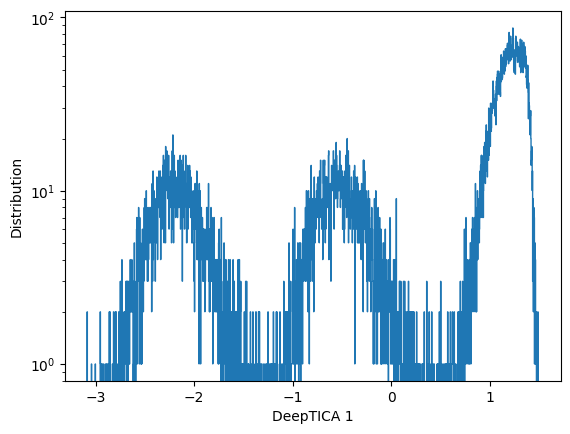

In [111]:
fig, ax = plt.subplots()
mask = results['r_fun'][:, 0].real > 0
eigfun = results['r_fun'][:, 1].real
ax.hist(eigfun[mask],bins=2000,histtype='step')
ax.set_yscale('log')
ax.set_xlabel('DeepTICA 1')
ax.set_ylabel('Distribution')

In [112]:
from mlcolvar.data import DictDataset
df = desc_df.copy()
labels = np.zeros(len(df))
# State 1
labels[np.argwhere(np.logical_and(eigfun < 0, mask))] = 1
# State 2
labels[np.argwhere(np.logical_and(eigfun > 0.5, mask))] = 2


df['labels'] = labels
sel = (df['labels'] != 0 )

descr_type = 'distances' #'angles' #'distances' #'angles' 
stride = 10

if descr_type == 'angles':
    # get descriptors
    X = df[sel].filter(regex='phi|psi|xi|theta').values[::stride]
    feat_names = df[sel].filter(regex='phi|psi|xi|theta').columns.values

    # get labels
    y = df[sel]['labels'].values[::stride]

elif descr_type == 'distances':
    # get descriptors
    X = df[sel].filter(regex='DIST').values[::stride]
    feat_names = df[sel].filter(regex='DIST').columns.values

    # get labels
    y = df[sel]['labels'].values[::stride]

# create dataset
dataset = DictDataset(dict(data=X,labels=y))
dataset.feature_names = feat_names
dataset

DictDataset( "data": [1666, 318], "labels": [1666], "data_type": descriptors )

In [113]:
from mlcolvar.explain.lasso import SparsityScoring, plot_lasso_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import SelectFromModel

In [114]:
def lasso_classification(dataset,
                         min_features = 0,
                         Cs = 40,
                         scale_inputs = True,
                         feature_names = None,
                         print_info = True,
                         plot = True
):
    """Perform sparse classification via LASSO on a given DictDataset (requires keys: "data" and "labels").
    The (inverse) regularization strength C is automatically chosen based on cross-validation on a set of values (Cs),
    see sklearn.linear_model.LogisticRegressionCV. The scoring function used is `SparsityScoring`, balancing the accuracy and the number of features.

    In the two-classes case a single classifier is built, otherwise a one-vs-rest classifier is constructed, composed by N different estimators are trained to classify each state from the others.
    
    Parameters
    ----------
    dataset : DictDataset
        dataset with 'data' and 'labels'
    min_features : int, optional
        minimum number of features, by default 0
    Cs : int or array-like, optional
        Each of the values in Cs describes the inverse of regularization strength. If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4. Like in support vector machines, smaller values specify stronger regularization., by default 40
    scale_inputs : bool, optional
        whether to standardize inputs based on mean and std.dev., by default True
    feature_names : list, optional
        names of the input features, if not given they are taken from `dataset.feature_names`, by default None
    print_info : bool, optional
        whether to print results, by default True
    plot : bool, optional
        whether to plot results, by default True

    See also
    --------
    mlcolvar.explain.lasso.SparsityScoring
        Scoring function used in LASSO classification

    Returns
    -------
    classifier: 
        optimized estimator
    feats: 
        dictionary with the names of the non-zero features, per label
    coeffs: 
        dictionary with the coefficients of the non-zero features, per label
    """

    # Convert dataset to numpy
    with torch.no_grad():
        raw_descriptors = dataset['data'].numpy()
        labels = dataset['labels'].numpy().astype(int)
    if feature_names is None:
        if dataset.feature_names is None:
            raise ValueError('Feature names not found (either in the dataset or as argument to the function).')
        feature_names = dataset.feature_names
    
    # Scaling inputs
    if scale_inputs:
        scaler = StandardScaler(with_mean=True, with_std=True)
        descriptors = scaler.fit_transform(raw_descriptors)
    else:
        descriptors = raw_descriptors

    # Define cross-validation for LASSO, using
    #   a custom scoring function based on accuracy and number of features
    scorer = SparsityScoring(min_features=min_features) 

    _classifier = LogisticRegressionCV(Cs=Cs, 
                                    solver='liblinear', 
                                    multi_class='ovr', 
                                    fit_intercept=False, 
                                    penalty='l1',
                                    n_jobs=20, 
                                    max_iter = 200,
                                    scoring=scorer)

    # Fit classifier
    feature_selector = SelectFromModel(_classifier)
    feature_selector.fit(descriptors, labels)

    classifier = feature_selector.estimator_

    # Get selected features and coefficients 
    feats = {}
    coeffs = {}

    for i,key in enumerate(classifier.coefs_paths_.keys()):

        index = np.abs(classifier.coef_).argsort()[i][::-1]

        sorted_feature_names = feature_names[index]
        sorted_coeffs = classifier.coef_[i,index]

        idx = np.argwhere ( np.abs(sorted_coeffs)>1e-5 )[:,0]
        selected_feature_names = sorted_feature_names[idx]
        selected_coeffs = sorted_coeffs[idx] 
        feats[key] = selected_feature_names
        coeffs[key] = selected_coeffs

        # display summary
        if print_info:
            #score = classifier.score(descriptors,labels)
            C_idx = np.argwhere(np.abs(classifier.Cs_ - classifier.C_[i]) < 1e-8)[0,0]
            score = classifier.scores_[key].mean(axis=0)[C_idx]
            accuracy = classifier.scoring.accuracy_from_score(score, len(selected_coeffs))

            print(f'======= LASSO results ({key}) ========')
            print(f'- Regularization : {classifier.C_[i]:.8f}')
            print(f'- Score          : {score:.2f}')
            print(f'- Accuracy       : {accuracy*100:.2f}%')
            print(f'- # features     : {len(selected_coeffs)}\n')
            print('Features: ')
            for j,(f,c) in enumerate(zip(selected_feature_names, selected_coeffs)):
                print(f'({j+1}) {f:13s}: {c:.6f}')
            print('==================================\n')

    # plot results
    if plot:
        plot_lasso_classification(classifier, feats, coeffs)

    return classifier, feats, coeffs

/home/novelli/encoderops/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1917: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


======= LASSO results (2) ========
- Regularization : 0.00202359
- Score          : -2.54
- Accuracy       : 99.46%
- # features     : 2

Features: 
(1) HB_DIST THR6-OG1s -- THR8-OG1s: -0.580422
(2) HB_DIST THR6-OG1s -- THR8-N: -0.011185



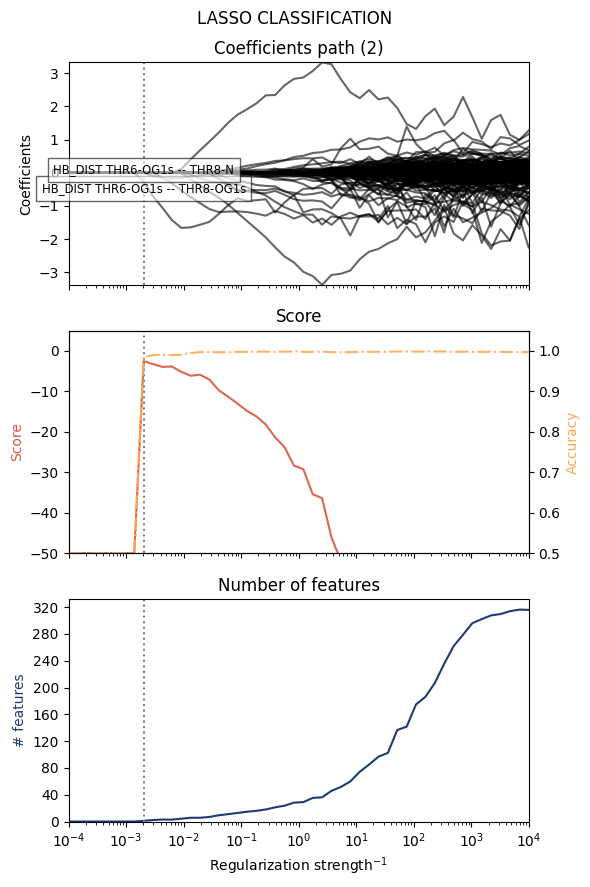

In [115]:
classifier, feats, coeffs = lasso_classification(dataset, Cs=50, plot=True)

Text(0, 0.5, 'Tica-1 $\\tau=$5.62ns')

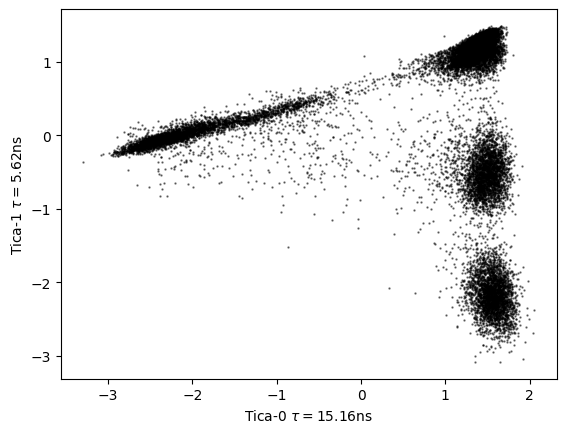

In [116]:
r_fun = results['r_fun'].real
def implied_timescale(ev, lagtime_ns: float = 0.2):
    if torch.is_tensor(ev):
        ev = ev.numpy(force=True)
    timescale = -1*(lagtime_ns / np.log(np.abs(ev)))
    return np.sort(timescale)[::-1]

idxs = (0, 1)
plt.scatter(r_fun[:, idxs[0]].real, r_fun[:, idxs[1]].real, color='k', s = 0.5, alpha=0.5)
taus = implied_timescale(results['eigenvalues'])
plt.xlabel(f'Tica-{idxs[0]} $\\tau=${taus[idxs[0]]:.2f}ns')
plt.ylabel(f'Tica-{idxs[1]} $\\tau=${taus[idxs[1]]:.2f}ns')

Text(0.5, 0, 'Deep-TICA 2')

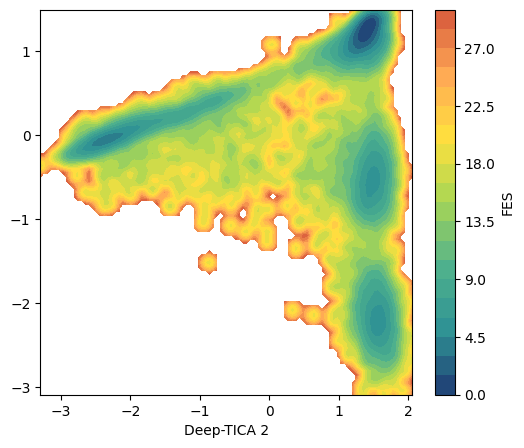

In [117]:
from mlcolvar.utils.fes import compute_fes
fig,ax = plt.subplots(1,1,figsize=(6,5),dpi=100)
max_fes = 30
# compute cvs
with torch.no_grad():
    s = torch.stack([r_fun[:, idx].real for idx in idxs]).T
fes,grid,bounds,error = compute_fes(s,
    blocks=1,
    bandwidth=0.01, scale_by='range',
    plot=False, plot_max_fes=200, ax = ax, eps=1e-10)

fes2 = fes.copy()
if max_fes is not None:
    fes2[fes2 > max_fes] = np.nan
extent = [item for sublist in bounds for item in sublist]
pp = ax.contourf(fes2, levels=20, cmap="fessa", extent=extent)  # ,vmax=max_fes)
cbar = plt.colorbar(pp, ax=ax)
cbar.set_label("FES")
# ax.set_xlim(-3, 2)
# ax.set_ylim(-3, 2)
ax.set_xlabel('Deep-TICA 1')
ax.set_xlabel('Deep-TICA 2')

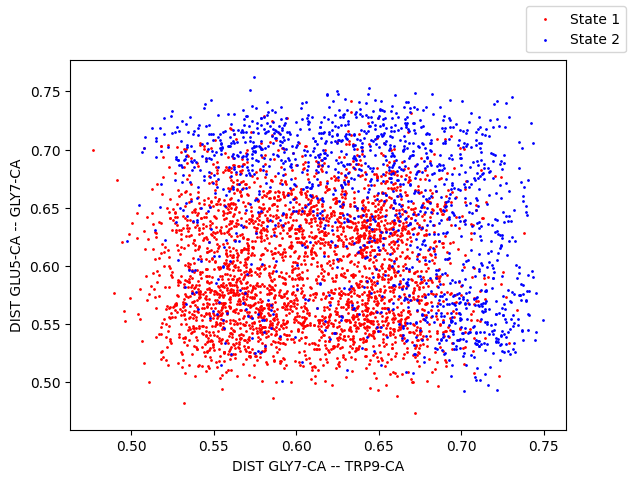

In [251]:
fig, ax = plt.subplots()
for k, feat in feats.items():
    assert len(feat) == 2
    colors = ['r', 'b']
    for lab_id, label in enumerate([1, 2]):
        mask = labels == label
        x = desc_df[feat[0]].values[mask]
        y = desc_df[feat[1]].values[mask]
        ax.scatter(x, y, color=colors[lab_id], s=1, label = f'State {label}')
    ax.set_xlabel(feat[0])
    ax.set_ylabel(feat[1])
fig.legend()

In [29]:
traj_1 = traj[::10][labels[::10] == 1]
traj_2 = traj[::10][labels[::10] == 2]

In [30]:
import mdtraj 
import nglview as nv

In [265]:
system_atoms = traj.top.select('resSeq 7 or resSeq 9')

In [266]:
system_atoms

array([ 99, 100, 101, 102, 103, 104, 105, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143])

In [269]:
traj_aligned = traj_1.superpose(traj_1, atom_indices=system_atoms, ref_atom_indices=system_atoms)

In [32]:
nv.show_mdtraj(traj_2)

NGLWidget(max_frame=1628)